<a href="https://colab.research.google.com/github/Mubasshir-Ali/Deep_Learning_Practice/blob/master/17_Moving_Average_Using_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common Patterns

# Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
  plt.plot(time[start:end], series[start:end], format, label = label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

# Trend And Seasonality

In [0]:
def trend(time, slop = 0):
  return slop * time

In [0]:
# Now let's generate a time series with a seasonal pattern:
def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi), 
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# Noise

In [0]:
# In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:
def white_noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

# Trend And Seasonality

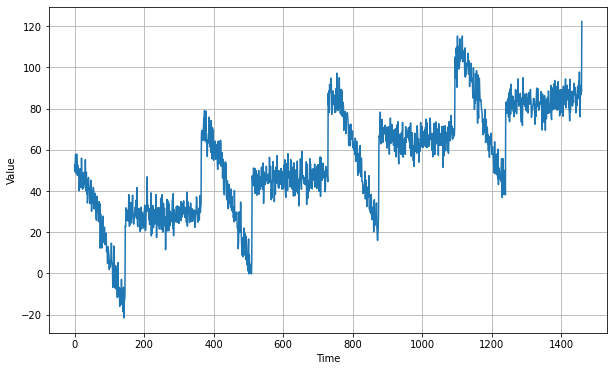

In [0]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Naive Forecast

In [0]:
naive_forecast = series[split_time - 1:-1]

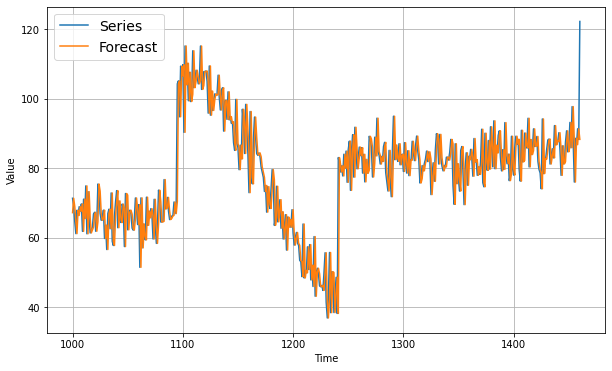

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

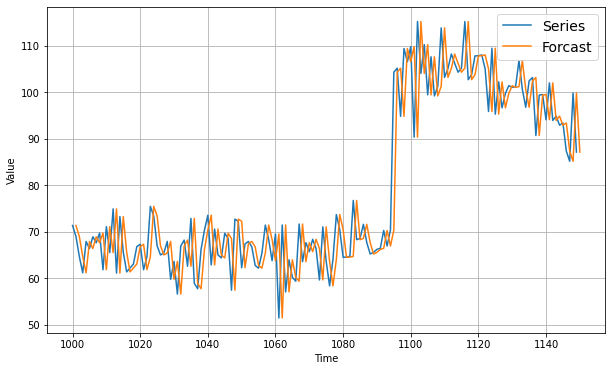

In [0]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid, start = 0, end = 150, label = "Series")
plot_series(time_valid, naive_forecast, start = 1, end = 151, label = "Forcast")

In [0]:
# Now let's compute the mean absolute error between the forecasts and the predictions in the validation period:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

# Moving Average

In [0]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [0]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

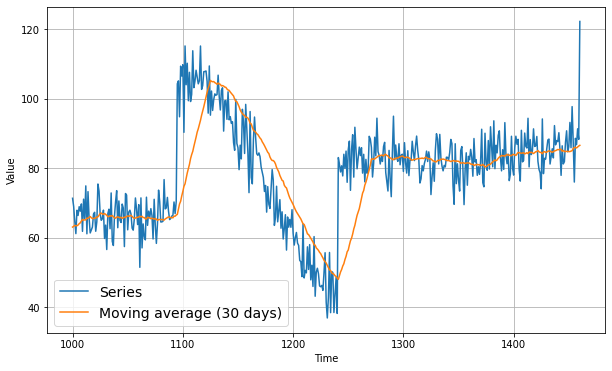

In [0]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [0]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.

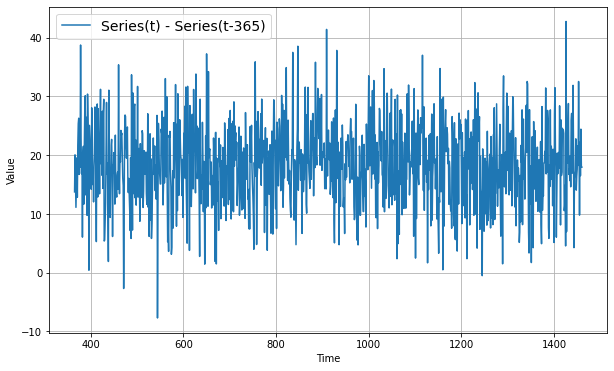

In [0]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize = (10, 6))
plot_series(diff_time, diff_series, label = "Series(t) - Series(t-365)")
plt.show()

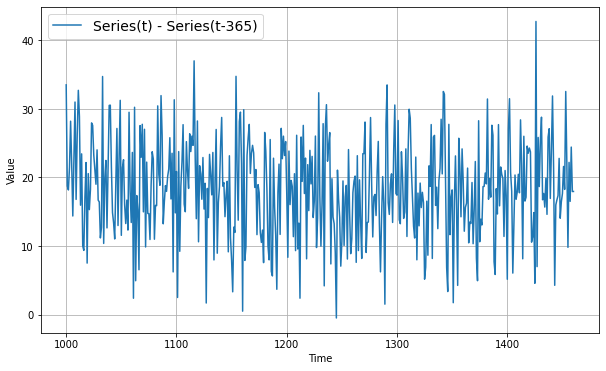

In [0]:
# Focusing on the validation period:
plt.figure(figsize = (10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label = "Series(t) - Series(t-365)")
plt.show()

<function matplotlib.pyplot.show>

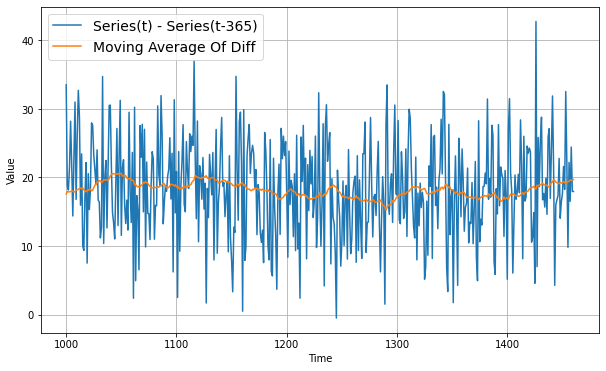

In [0]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize = (10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label = "Series(t) - Series(t-365)")
plot_series(time_valid, diff_moving_avg, label = "Moving Average Of Diff")
plt.show

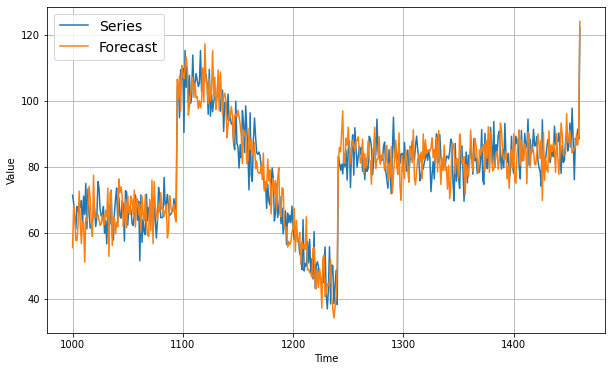

In [0]:
# Now let's bring back the trend and seasonality by adding the past values from t – 365:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, diff_moving_avg_plus_past, label = "Forecast")
plt.show()

In [0]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.8393105629958955

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

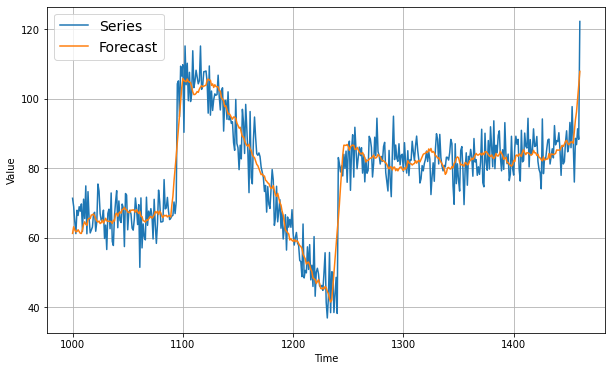

In [0]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label = "Forecast")
plt.show()

In [0]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.566859958970772